### Baltimore City Police Emergency and Non-Emergency 911 Calls for Service, 2015-2018

This notebook will analyze Baltimore's 911 police calls for service data, which can be obtained from [Open Baltimore](https://data.baltimorecity.gov/Public-Safety/911-Police-Calls-for-Service/xviu-ezkt). 

The data contains the following fields:


* recordId: Int variable, record identifier
* callDateTime: Floating timestamp, YYYY-MM-DD HH:MM:SS
* priority: String variable, priority of call
* district: String variable, quadrant of Baltimore	
* description: String variable, description of the emergency call
* callNumber: String variable, call identifier
* incidentLocation: String variable, location of incident 	
* location: String variable, location of call

The calls dates range from 2015-01-01 to present (as of 2018-06-14). There are 3.55 million rows, each row a call. Data is automatically refreshed multiple times a day.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import re
from string import punctuation
from datetime import datetime, timedelta
import folium
from folium import plugins

%matplotlib inline

In [49]:
calls = pd.read_json('https://data.baltimorecity.gov/resource/m8g9-abgb.json?$limit=5000000')
calls.head()

,calldatetime,callnumber,description,district,incidentlocation,location,location_address,location_city,location_state,priority,recordid
0,2018-02-05T11:29:00.000,P180361209,INVEST,CD,0 CHARLES PZ,NaN,0 CHARLES,PZ BALTIMORE,MD,Low,3213567
1,2017-09-25T06:07:00.000,P172680397,PRKG COMPLAINT,SD,E100,NaN,NaN,NaN,NaN,Non-Emergency,2874965
2,2018-06-04T14:02:00.000,P181551495,ARMED PERSON,WD,N PAYSON ST/PENROSE AV,NaN,N PAYSON ST,BALTIMORE,MD,High,3529597
3,2018-06-04T14:11:00.000,P181551516,DISORDERLY,SD,2000 E MCCOMAS ST,"{'type': 'Point', 'coordinates': [-76.58958, 3...",2000 E MCCOMAS ST,BALTIMORE,MD,Medium,3529620
4,2018-06-04T14:08:00.000,P181551501,NARCOTICS ONVIEW,CD,200 N EUTAW ST,"{'type': 'Point', 'coordinates': [-76.621111, ...",200 N EUTAW ST,BALTIMORE,MD,Medium,3529624


### Creating New features

In [54]:
"""Extracts call date, hour, and day from callDateTime"""
calls['timeStamp'] = pd.to_datetime(calls['calldatetime'])
calls['callDate'] = calls['timeStamp'].dt.date
calls['Hour'] = calls['timeStamp'].apply(lambda x: x.hour)
calls['Day'] = calls['timeStamp'].dt.strftime('%A')
calls.head()

,calldatetime,callnumber,description,district,incidentlocation,location,location_address,location_city,location_state,priority,recordid,timeStamp,callDate,Hour,Day
0,2018-02-05T11:29:00.000,P180361209,INVEST,CD,0 CHARLES PZ,NaN,0 CHARLES,PZ BALTIMORE,MD,Low,3213567,2018-02-05 11:29:00,2018-02-05,11,Monday
1,2017-09-25T06:07:00.000,P172680397,PRKG COMPLAINT,SD,E100,NaN,NaN,NaN,NaN,Non-Emergency,2874965,2017-09-25 06:07:00,2017-09-25,6,Monday
2,2018-06-04T14:02:00.000,P181551495,ARMED PERSON,WD,N PAYSON ST/PENROSE AV,NaN,N PAYSON ST,BALTIMORE,MD,High,3529597,2018-06-04 14:02:00,2018-06-04,14,Monday
3,2018-06-04T14:11:00.000,P181551516,DISORDERLY,SD,2000 E MCCOMAS ST,"{'type': 'Point', 'coordinates': [-76.58958, 3...",2000 E MCCOMAS ST,BALTIMORE,MD,Medium,3529620,2018-06-04 14:11:00,2018-06-04,14,Monday
4,2018-06-04T14:08:00.000,P181551501,NARCOTICS ONVIEW,CD,200 N EUTAW ST,"{'type': 'Point', 'coordinates': [-76.621111, ...",200 N EUTAW ST,BALTIMORE,MD,Medium,3529624,2018-06-04 14:08:00,2018-06-04,14,Monday


In [56]:
def long_lat(loc):
    """Extracts longitude and latitude from the locations column"""
    lat = None
    long = None
    
    if loc:
        try:
            loc = loc['coordinates']
            lat = loc[1]
            long = loc[0] 
        except:
            pass 
    else:
        return 
    return pd.Series([lat, long], index=['lat', 'long'])

calls[['lat', 'long']] = calls['location'][:].apply(long_lat)

calls.head()

,calldatetime,callnumber,description,district,incidentlocation,location,location_address,location_city,location_state,priority,recordid,timeStamp,callDate,Hour,Day,lat,long
0,2018-02-05T11:29:00.000,P180361209,INVEST,CD,0 CHARLES PZ,NaN,0 CHARLES,PZ BALTIMORE,MD,Low,3213567,2018-02-05 11:29:00,2018-02-05,11,Monday,NaN,NaN
1,2017-09-25T06:07:00.000,P172680397,PRKG COMPLAINT,SD,E100,NaN,NaN,NaN,NaN,Non-Emergency,2874965,2017-09-25 06:07:00,2017-09-25,6,Monday,NaN,NaN
2,2018-06-04T14:02:00.000,P181551495,ARMED PERSON,WD,N PAYSON ST/PENROSE AV,NaN,N PAYSON ST,BALTIMORE,MD,High,3529597,2018-06-04 14:02:00,2018-06-04,14,Monday,NaN,NaN
3,2018-06-04T14:11:00.000,P181551516,DISORDERLY,SD,2000 E MCCOMAS ST,"{'type': 'Point', 'coordinates': [-76.58958, 3...",2000 E MCCOMAS ST,BALTIMORE,MD,Medium,3529620,2018-06-04 14:11:00,2018-06-04,14,Monday,39.264612,-76.589580
4,2018-06-04T14:08:00.000,P181551501,NARCOTICS ONVIEW,CD,200 N EUTAW ST,"{'type': 'Point', 'coordinates': [-76.621111, ...",200 N EUTAW ST,BALTIMORE,MD,Medium,3529624,2018-06-04 14:08:00,2018-06-04,14,Monday,39.292098,-76.621111


In [58]:
calls.to_pickle('baltimore_911_calls')

In [50]:
calls = pd.read_pickle('baltimore_911_calls')

### Data Visualization

In [51]:
# Group call counts by each day starting from 2015-01-01
call_count = calls.groupby('callDate').count()['recordid']

In [139]:
call_count

callDate
2015-01-01    2549
2015-01-02    2603
2015-01-03    2258
2015-01-04    2192
2015-01-05    2694
2015-01-06    2230
2015-01-07    2376
2015-01-08    2334
2015-01-09    2460
2015-01-10    2435
2015-01-11    2414
2015-01-12    2469
2015-01-13    2737
2015-01-14    2714
2015-01-15    2790
2015-01-16    3087
2015-01-17    3032
2015-01-18    2580
2015-01-19    2769
2015-01-20    3028
2015-01-21    2709
2015-01-22    2920
2015-01-23    3118
2015-01-24    2947
2015-01-25    2698
2015-01-26    2780
2015-01-27    2695
2015-01-28    2945
2015-01-29    2989
2015-01-30    3403
              ... 
2018-05-16    2716
2018-05-17    2881
2018-05-18    2767
2018-05-19    2520
2018-05-20    2535
2018-05-21    2783
2018-05-22    2900
2018-05-23    3313
2018-05-24    3326
2018-05-25    3201
2018-05-26    2969
2018-05-27    2440
2018-05-28    2678
2018-05-29    2915
2018-05-30    2825
2018-05-31    2978
2018-06-01    3282
2018-06-02    2802
2018-06-03    2338
2018-06-04    2882
2018-06-05    3031
201

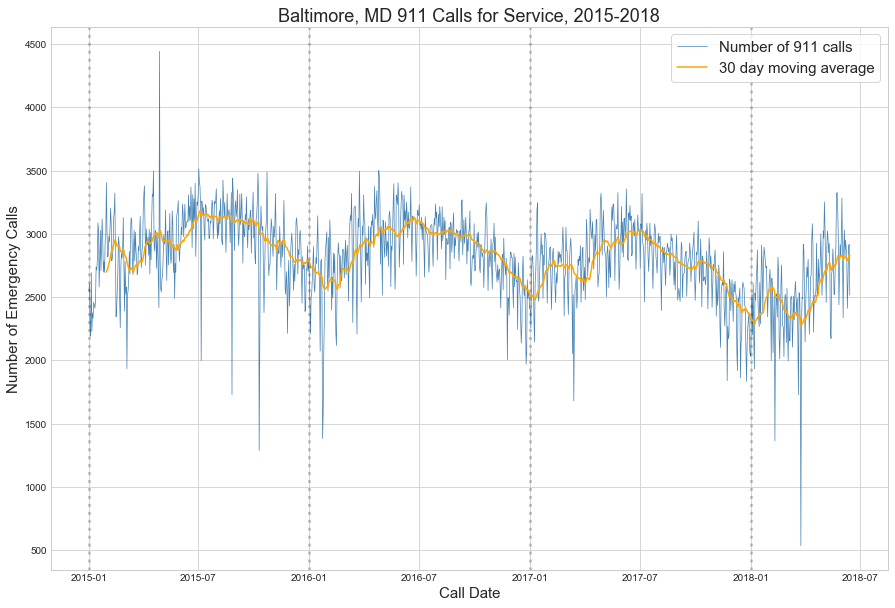

In [118]:
calls_for_service, ax = plt.subplots()

# graph countplot of number of calls each day
c = call_count.plot(figsize=(15,10), label = 'Number of 911 calls', linewidth=0.7, color='steelblue')

# graph rolling average for every thirty days
c = call_count.rolling(window=30).mean().plot(figsize=(15,10), label = '30 day moving average', color='orange')

def yearly_mark(start_year, end_year):
    """Separates each year in graph with vertical line"""
    for i in range(start_year, end_year+1):
        date = str(i)+'-01-01'
        plt.axvline(date, color='black', linewidth=3, linestyle=':', alpha=0.2)
    
yearly_mark(2015, 2018)

plt.legend(prop={'size': 15}, loc=1, frameon=True)
plt.title('Baltimore, MD 911 Calls for Service, 2015-2018', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)
plt.show()

calls_for_service.savefig('all-graphs/911_calls_for_service.png', dpi = 400, bbox_inches = 'tight')

There is a spike in 911 calls around April/May of 2015. If we zoom into this part of the graph by limiting the x-axis to just 2015 calls, we see that this happens on April 27th, 2015. This was the date of Freddie Gray's funeral, which was followed by a sharp increase in civil disorder in Baltimore.

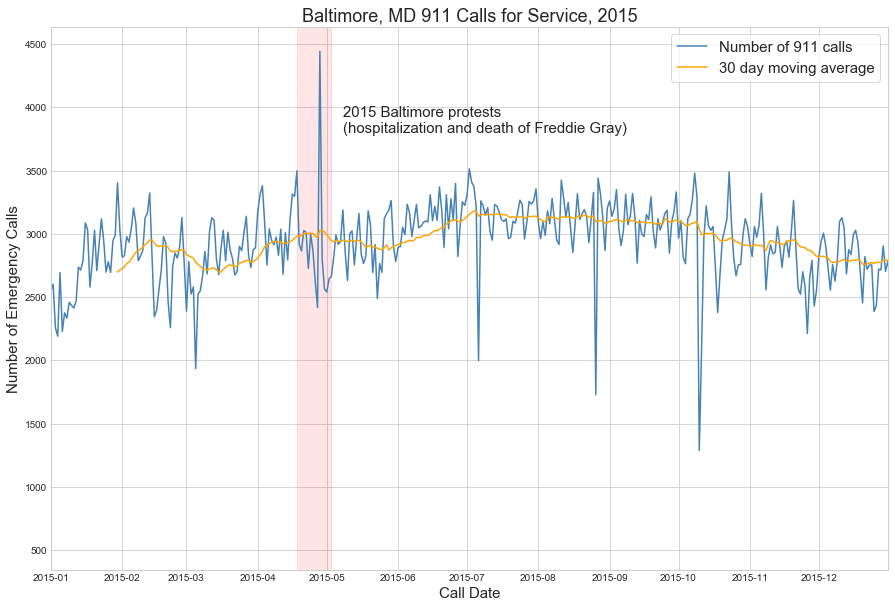

In [97]:
calls_for_service_2015, ax = plt.subplots()

# to isolate year 2015, set range starting from 2015-01-01 to 2015-12-31
startdate = datetime.strptime('2015-01-01', "%Y-%m-%d").date()
enddate = datetime.strptime('2015-12-31', "%Y-%m-%d").date()

# graph number of calls per day
calls.groupby('callDate').count()['recordid'].plot(figsize=(15,10),label = 'Number of 911 calls', color='steelblue')
calls.groupby('callDate').count()['recordid'].rolling(window=30).mean().plot(figsize=(15,10), label = '30 day moving average', color='orange')

# limit x axis to 2015 only
plt.xlim([startdate,enddate])

# label and mark spike in 911 call
plt.axvspan('2015-04-18', '2015-05-03', alpha=0.1, color='r')
plt.text('2015-05-08', 3800, '2015 Baltimore protests\n(hospitalization and death of Freddie Gray)', fontsize=15)

plt.legend(prop={'size': 15}, frameon=True)
plt.title('Baltimore, MD 911 Calls for Service, 2015', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)
plt.show()

calls_for_service_2015.savefig('all-graphs/911_calls_for_service_2015.png', dpi = 400, bbox_inches = 'tight')

Here are the top 5 most common reasons for 911 call service. We will disregard the top reason '911/NO VOICE', since we are only interested in categorized reasons for the call. We will also exclude routine non-emergency traffic stops.

In [54]:
calls['description'].value_counts(ascending=False).head(10)

911/NO  VOICE       538337
DISORDERLY          309364
Traffic Stop        222750
COMMON ASSAULT      153165
AUTO ACCIDENT       143734
NARCOTICSOutside    126482
SILENT ALARM        105813
FAMILY DISTURB       87541
Repairs/Service      79591
OTHER                77152
Name: description, dtype: int64

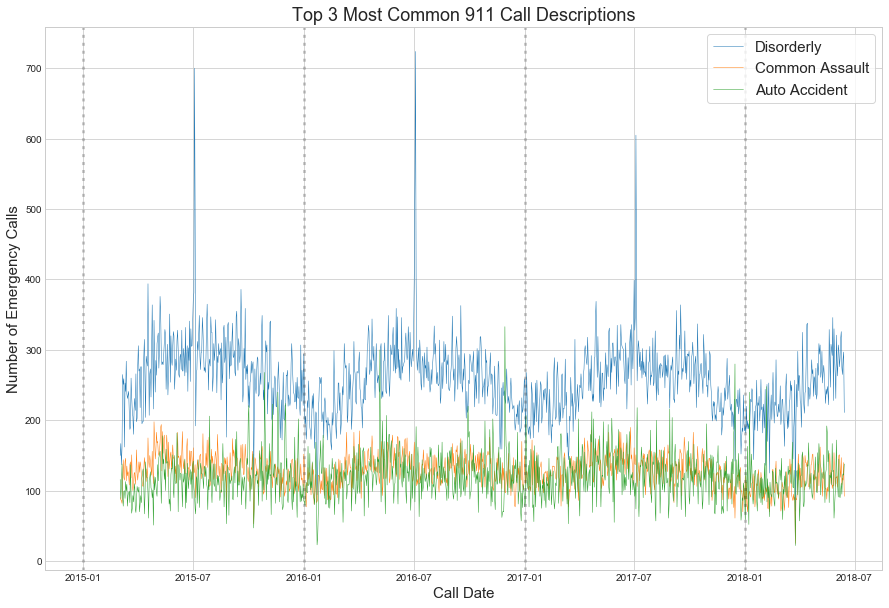

In [98]:
top_calls_for_service, ax = plt.subplots()

def top_calls(description):
    call_description = calls[calls['description'] == description].groupby('callDate').count()['recordid']
    call_description.plot(figsize=(15,10), label = description.title(), linewidth=0.5)
    
top_calls('DISORDERLY')    
top_calls('COMMON ASSAULT')
top_calls('AUTO ACCIDENT')

plt.legend(prop={'size': 15}, frameon=True)
plt.title('Top 3 Most Common 911 Call Descriptions', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)

yearly_mark(2015, 2018)

top_calls_for_service.savefig('all-graphs/top_calls_for_service.png', dpi = 400, bbox_inches = 'tight')

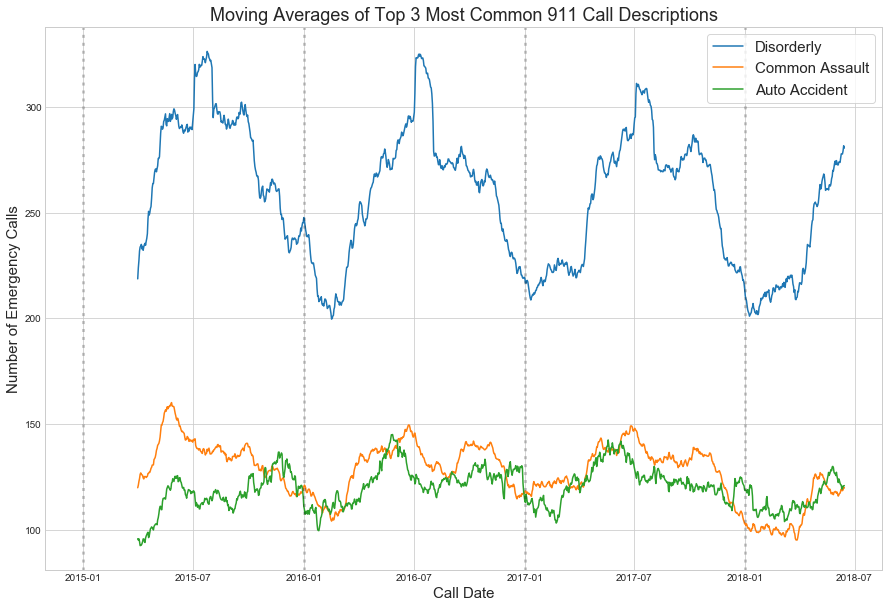

In [116]:
top_calls_for_service_average, ax = plt.subplots()

def top_calls(description):
    call_description = calls[calls['description'] == description].groupby('callDate').count()['recordid']
    call_description.rolling(window=30).mean().plot(figsize=(15,10), label = description.title())
    
top_calls('DISORDERLY')    
top_calls('COMMON ASSAULT')
top_calls('AUTO ACCIDENT')

plt.legend(prop={'size': 15}, frameon=True)
plt.title('Moving Averages of Top 3 Most Common 911 Call Descriptions', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)

yearly_mark(2015, 2018)

top_calls_for_service_average.savefig('all-graphs/top_calls_for_service_average.png', dpi = 400, bbox_inches = 'tight')

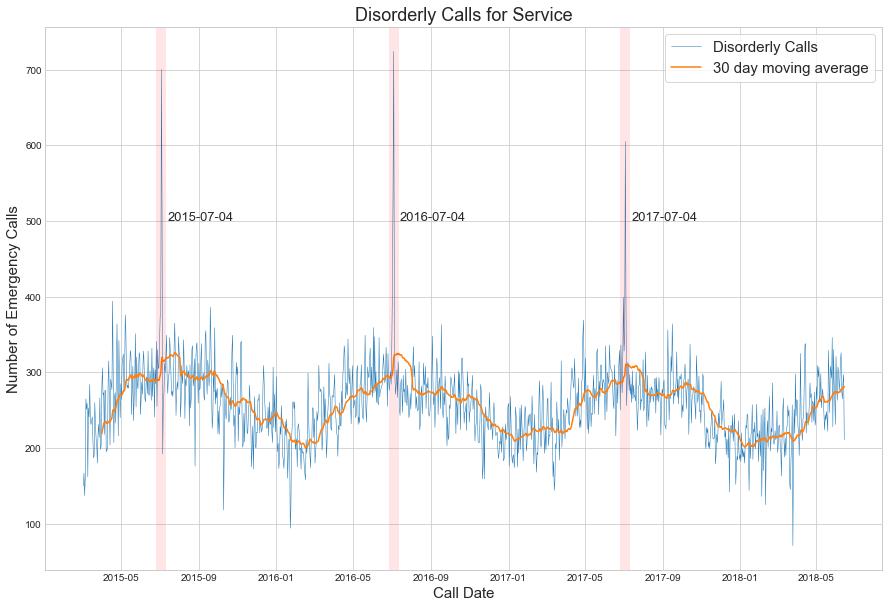

In [101]:
disorderly_calls_for_service, ax = plt.subplots()

call_disorderly.plot(figsize=(15,10), label = 'Disorderly Calls', linewidth=0.5,)
call_disorderly.rolling(window=30).mean().plot(figsize=(15,10), label = '30 day moving average')

def july_4th(date):
    """Marks and labels dates with spike in disorderly calls"""
    plt.axvline(date, color='r', linewidth=10, alpha=0.1)
    date_1 = datetime.strptime(date, "%Y-%m-%d")
    plt.text(date_1 + timedelta(days=10), 500, date, fontsize=13)
    
july_4th('2015-07-04')
july_4th('2016-07-04')
july_4th('2017-07-04')

plt.legend(prop={'size': 15}, frameon=True)
plt.title('Disorderly Calls for Service', fontsize=18)
ax.set_xlabel("Call Date", fontsize=15)
ax.set_ylabel("Number of Emergency Calls", fontsize=15)

disorderly_calls_for_service.savefig('all-graphs/disorderly_calls_for_service.png', dpi = 400, bbox_inches = 'tight')

## Heatmaps

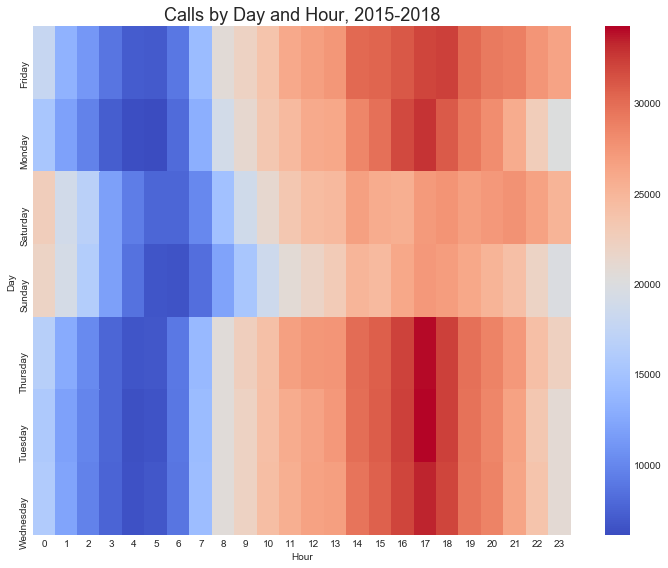

In [117]:
# heatmap of call frequency by day of the week and hour
plt.figure(figsize=(10,8))
calls_dayHour_heatmap = sns.heatmap(calls_dayHour, cmap='coolwarm')
plt.title('Calls by Day and Hour, 2015-2018', fontsize=18)

plt.tight_layout()

plt.savefig('all-graphs/calls_dayHour_heatmap.png', dpi = 400, bbox_inches = 'tight')

#### Use the following [nbviewer](https://nbviewer.jupyter.org/github/ymericson/example-notebook/blob/master/Baltimore%20911%20Calls.ipynb) link to view the below JavaScript content 

In [59]:
# map Baltimore using central latitude and longitude
baltLatLong = [39.299236, -76.609383]
baltMap = folium.Map(baltLatLong, zoom_start=12)

# convert lat and long from calls in a list-in-list format for heatmap
calls_latLong_list = calls[['lat', 'long']].dropna()[:50000].values.tolist()

# plot heatmap
baltMap.add_child(plugins.HeatMap(calls_latLong_list, radius=10))
baltMap